In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Using MultinomialNB from sklearn

This relies on a standard, prebuilt pipeline for machine learning with CountVectorizer and MultinomialNB to classify text.

*   Leverages CountVectorizer to extract features (term frequency counts).
*   Automatically handles tokenization and vectorization as part of the pipeline.
*   Uses sklearn's prebuilt metric functions for calculation.

We expect it to perform faster due to the optimized sklearn library.



In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import string
import re
import nltk
import pandas as pd
from tqdm import tqdm
import time

# Download required NLTK data
nltk.download('stopwords', quiet=True)

# Load Data Functions
def get_texts_labels(file_path):
    texts, labels = [], []
    with open(file_path, 'r') as f:
        for line in f:
            record = json.loads(line.strip())
            texts.append(record['text'])
            labels.append(record['label'])
    return texts, labels

def get_texts(file_path):
    texts = []
    with open(file_path, 'r') as f:
        for line in f:
            record = json.loads(line.strip())
            texts.append(record['text'])
    return texts

# Preprocessing Function
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = text.replace('\n', ' ')
    text = re.sub(r'[^a-zA-Z\s.,!?]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words or word in '.,!?'])
    return text

# Define file paths
file_path = '/content/drive/MyDrive/project/COMP6781_MNBvBERT_MGTDetect-main'
SemEval_train_file_path = file_path + '/SemEval_data/subtaskA_train_monolingual.jsonl'
SemEval_val_file_path = file_path + '/SemEval_data/subtaskA_dev_monolingual.jsonl'
SemEval_test_file_path = file_path + '/SemEval_data/subtaskA_monolingual_test1.jsonl'  # Added SemEval test path
GenAI_train_file_path = file_path + '/GenAI_data/en_train.jsonl'
GenAI_val_file_path = file_path + '/GenAI_data/en_dev.jsonl'
GenAI_test_file_path = file_path + '/GenAI_data/en_test.jsonl'  # Added GenAI test path

# Load datasets
print("Loading datasets...")
SemEval_train_texts, SemEval_train_labels = get_texts_labels(SemEval_train_file_path)
SemEval_val_texts, SemEval_val_labels = get_texts_labels(SemEval_val_file_path)
SemEval_test_texts, SemEval_test_labels = get_texts_labels(SemEval_test_file_path)  # Load test set

GenAI_train_texts, GenAI_train_labels = get_texts_labels(GenAI_train_file_path)
GenAI_val_texts, GenAI_val_labels = get_texts_labels(GenAI_val_file_path)

# Step 1: Split 10% of the GenAI training set for testing and remove it from the training data
GenAI_train_texts, GenAI_test_texts, GenAI_train_labels, GenAI_test_labels = train_test_split(
    GenAI_train_texts, GenAI_train_labels, test_size=0.1, stratify=GenAI_train_labels, random_state=42
)

# Step 2: Stratified Sampling to Match SemEval Dataset Size
train_data, _ = train_test_split(
    list(zip(GenAI_train_texts, GenAI_train_labels)),
    train_size=len(SemEval_train_texts),
    stratify=GenAI_train_labels,
    random_state=42
)
GenAI_train_texts, GenAI_train_labels = map(list, zip(*train_data))

# Encode labels
label_encoder = LabelEncoder()
SemEval_train_labels = label_encoder.fit_transform(SemEval_train_labels)
SemEval_val_labels = label_encoder.transform(SemEval_val_labels)
SemEval_test_labels = label_encoder.transform(SemEval_test_labels)
GenAI_train_labels = label_encoder.transform(GenAI_train_labels)
GenAI_val_labels = label_encoder.transform(GenAI_val_labels)
GenAI_test_labels = label_encoder.transform(GenAI_test_labels)

def calculate_metrics_and_confusion(pipeline, texts, labels, split_name):
    predictions = pipeline.predict(texts)
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')
    confusion = pd.crosstab(pd.Series(labels, name='Actual'), pd.Series(predictions, name='Predicted'))

    print(f"\n{split_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(confusion)

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}, confusion

# Train and evaluate sklearn model on SemEval dataset
print("\nTraining and evaluating sklearn model on SemEval dataset...")
train_metrics, val_metrics, test_metrics, confusion_matrices = {}, {}, {}, {}

# Create pipeline and train on SemEval
pipeline = make_pipeline(
    CountVectorizer(preprocessor=preprocess_text),
    MultinomialNB()
)

# Measure training time
start_time = time.time()
pipeline.fit(SemEval_train_texts, SemEval_train_labels)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds.")

# Calculate and print metrics for each data split
train_metrics['SemEval'], confusion_matrices['SemEval_train'] = calculate_metrics_and_confusion(
    pipeline, SemEval_train_texts, SemEval_train_labels, "Training Set"
)
val_metrics['SemEval'], confusion_matrices['SemEval_val'] = calculate_metrics_and_confusion(
    pipeline, SemEval_val_texts, SemEval_val_labels, "Validation Set"
)
test_metrics['SemEval'], confusion_matrices['SemEval_test'] = calculate_metrics_and_confusion(
    pipeline, SemEval_test_texts, SemEval_test_labels, "Test Set"
)

# Repeat for GenAI dataset
print("\nTraining and evaluating sklearn model on GenAI dataset...")

# Measure training time
start_time = time.time()
pipeline.fit(GenAI_train_texts, GenAI_train_labels)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds.")

train_metrics['GenAI'], confusion_matrices['GenAI_train'] = calculate_metrics_and_confusion(
    pipeline, GenAI_train_texts, GenAI_train_labels, "Training Set"
)
val_metrics['GenAI'], confusion_matrices['GenAI_val'] = calculate_metrics_and_confusion(
    pipeline, GenAI_val_texts, GenAI_val_labels, "Validation Set"
)
test_metrics['GenAI'], confusion_matrices['GenAI_test'] = calculate_metrics_and_confusion(
    pipeline, GenAI_test_texts, GenAI_test_labels, "Test Set"
)

# Summary of all results
print("\nResults Summary:")
print("\nSemEval Dataset Metrics:")
print("Training Set Metrics:", train_metrics['SemEval'])
print("Validation Set Metrics:", val_metrics['SemEval'])
print("Test Set Metrics:", test_metrics['SemEval'])

print("\nGenAI Dataset Metrics:")
print("Training Set Metrics:", train_metrics['GenAI'])
print("Validation Set Metrics:", val_metrics['GenAI'])
print("Test Set Metrics:", test_metrics['GenAI'])


Loading datasets...

Training and evaluating sklearn model on SemEval dataset...
Training completed in 72.35 seconds.

Training Set Metrics:
Accuracy: 0.7214
Precision: 0.7269
Recall: 0.7214
F1 Score: 0.7214

Confusion Matrix:
Predicted      0      1
Actual                 
0          42952  20399
1          12962  43444

Validation Set Metrics:
Accuracy: 0.5144
Precision: 0.5144
Recall: 0.5144
F1 Score: 0.5140

Confusion Matrix:
Predicted     0     1
Actual               
0          1213  1287
1          1141  1359

Test Set Metrics:
Accuracy: 0.8413
Precision: 0.8480
Recall: 0.8413
F1 Score: 0.8412

Confusion Matrix:
Predicted      0      1
Actual                 
0          14649   1623
1           3816  14184

Training and evaluating sklearn model on GenAI dataset...
Training completed in 42.79 seconds.

Training Set Metrics:
Accuracy: 0.7434
Precision: 0.7656
Recall: 0.7434
F1 Score: 0.7473

Confusion Matrix:
Predicted      0      1
Actual                 
0          35417   9469


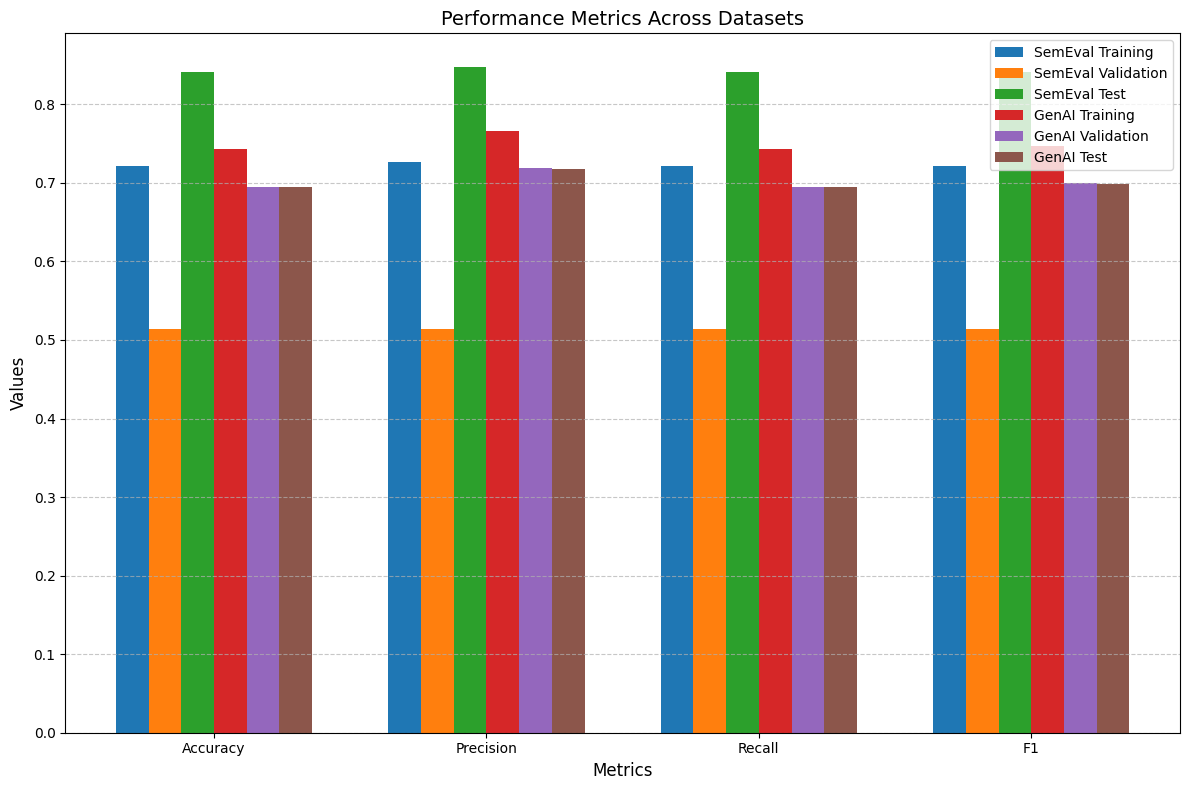

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data
datasets = ["SemEval Training", "SemEval Validation", "SemEval Test",
            "GenAI Training", "GenAI Validation", "GenAI Test"]
metrics = ["Accuracy", "Precision", "Recall", "F1"]

# SemEval metrics
semeval_metrics = [
    [0.7214, 0.7269, 0.7214, 0.7214],  # Training
    [0.5144, 0.5144, 0.5144, 0.5140],  # Validation
    [0.8413, 0.8480, 0.8413, 0.8412]   # Test
]

# GenAI metrics
genai_metrics = [
    [0.7434, 0.7656, 0.7434, 0.7473],  # Training
    [0.6952, 0.7192, 0.6952, 0.6999],  # Validation
    [0.6943, 0.7183, 0.6943, 0.6991]   # Test
]

# Combine data for plotting
data = semeval_metrics + genai_metrics
data = np.array(data)

# Plotting
x = np.arange(len(metrics))
bar_width = 0.12

plt.figure(figsize=(12, 8))
for i, dataset in enumerate(datasets):
    plt.bar(x + i * bar_width, data[i], width=bar_width, label=dataset)

# Add labels and title
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.title("Performance Metrics Across Datasets", fontsize=14)
plt.xticks(x + bar_width * 2.5, metrics)
plt.legend(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


# Using Custom Implementation (similar to assignment)

Implements a custom Naive Bayes algorithm from scratch, involving manual steps like vocabulary building, log-likelihood calculation, and evaluation.

We expect it to take slightly longer and be computationally heavier due to manual processing and likelihood calculations.

In [ ]:
import json
import time
import numpy as np
import pandas as pd
import string
import re
import math
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
import nltk
import pandas as pd
nltk.download('stopwords')

# Constants
SMOOTHING_FACTOR = 0.2

# Load Data Functions
def get_texts_labels(file_path):
    """Load texts and labels from JSONL file"""
    texts, labels = [], []
    with open(file_path, 'r') as f:
        for line in f:
            record = json.loads(line.strip())
            texts.append(record['text'])
            labels.append(record['label'])
    return texts, labels

def get_texts(file_path):
    """Load only texts from JSONL file"""
    texts = []
    with open(file_path, 'r') as f:
        for line in f:
            record = json.loads(line.strip())
            texts.append(record['text'])
    return texts

def preprocess_text(text):
    """Preprocess text while preserving important features for detection"""
    stop_words = set(stopwords.words('english'))

    text = text.lower()
    text = text.replace('\n', ' ')
    text = re.sub(r'[^a-zA-Z\s.,!?]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words or word in '.,!?'])

    return text

def train_and_evaluate_custom(train_texts, train_labels, val_texts, val_labels, test_texts, test_labels):
    """Train and evaluate using custom Naive Bayes implementation for train, validation, and test sets"""
    # Measure training time
    start_time = time.time()

    # Create training dataframe
    train_df = pd.DataFrame({
        'text': [preprocess_text(text) for text in train_texts],
        'label': train_labels
    })

    # Build vocabularies
    full_vocab, human_vocab, machine_vocab = build_vocabulary(train_df)

    # Calculate likelihood
    likelihood = calculate_log_likelihood(full_vocab, human_vocab, machine_vocab)

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds.")

    # Evaluate on train, validation, and test sets
    results_train = evaluate_model(pd.DataFrame({'text': [preprocess_text(text) for text in train_texts], 'label': train_labels}), likelihood)
    results_val = evaluate_model(pd.DataFrame({'text': [preprocess_text(text) for text in val_texts], 'label': val_labels}), likelihood)
    results_test = evaluate_model(pd.DataFrame({'text': [preprocess_text(text) for text in test_texts], 'label': test_labels}), likelihood)

    return results_train, results_val, results_test, likelihood

def build_vocabulary(df):
    """Build vocabularies for human and machine text"""
    human_vocab = {}
    machine_vocab = {}
    full_vocab = {}

    for _, row in df.iterrows():
        words = row['text'].split()
        for word in words:
            full_vocab[word] = full_vocab.get(word, 0) + 1
            if row['label'] == 0:  # human
                human_vocab[word] = human_vocab.get(word, 0) + 1
            else:  # machine
                machine_vocab[word] = machine_vocab.get(word, 0) + 1

    return full_vocab, human_vocab, machine_vocab

def calculate_log_likelihood(vocab, human_vocab, machine_vocab, smoothing_factor=SMOOTHING_FACTOR):
    """Calculate log likelihood probabilities"""
    likelihood = {}

    number_instances_human = sum(human_vocab.values())
    number_instances_machine = sum(machine_vocab.values())
    number_types = len(vocab)

    for word, count in vocab.items():
        likelihood[word] = {}

        human_word_count = human_vocab.get(word, 0)
        machine_word_count = machine_vocab.get(word, 0)

        human_probability = (human_word_count + smoothing_factor) / (number_instances_human + smoothing_factor * number_types)
        machine_probability = (machine_word_count + smoothing_factor) / (number_instances_machine + smoothing_factor * number_types)

        likelihood[word]['human'] = math.log(human_probability)
        likelihood[word]['machine'] = math.log(machine_probability)

    return likelihood

def evaluate_model(df, likelihood):
    """Evaluate custom model performance"""
    metrics = {
        'true_positives': 0,
        'false_positives': 0,
        'true_negatives': 0,
        'false_negatives': 0
    }

    y_true = []
    y_pred = []

    for _, row in df.iterrows():
        true_label = row['label']
        predicted_class, _ = classify_text(row['text'], likelihood, 0.5, 0.5)
        predicted_label = 1 if predicted_class == 'machine' else 0

        y_true.append(true_label)
        y_pred.append(predicted_label)

        if true_label == 1 and predicted_label == 1:
            metrics['true_positives'] += 1
        elif true_label == 1 and predicted_label == 0:
            metrics['false_negatives'] += 1
        elif true_label == 0 and predicted_label == 0:
            metrics['true_negatives'] += 1
        elif true_label == 0 and predicted_label == 1:
            metrics['false_positives'] += 1

    tp = metrics['true_positives']
    fp = metrics['false_positives']
    tn = metrics['true_negatives']
    fn = metrics['false_negatives']

    metrics['accuracy'] = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    metrics['precision'] = tp / (tp + fp) if (tp + fp) > 0 else 0
    metrics['recall'] = tp / (tp + fn) if (tp + fn) > 0 else 0
    metrics['f1'] = 2 * (metrics['precision'] * metrics['recall']) / (metrics['precision'] + metrics['recall']) if (metrics['precision'] + metrics['recall']) > 0 else 0

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    metrics['confusion_matrix'] = cm

    return metrics

def classify_text(text, likelihood, human_prior, machine_prior):
    """Classify text using custom implementation"""
    tokens = preprocess_text(text).split()

    log_score_human = math.log(human_prior)
    log_score_machine = math.log(machine_prior)

    for token in tokens:
        if token in likelihood:
            log_score_human += likelihood[token]['human']
            log_score_machine += likelihood[token]['machine']
        else:
            unseen_adjustment = math.log(SMOOTHING_FACTOR / (len(likelihood) + 1))
            log_score_human += unseen_adjustment
            log_score_machine += unseen_adjustment

    predicted_class = 'human' if log_score_human > log_score_machine else 'machine'
    scores = {'human': log_score_human, 'machine': log_score_machine}

    return predicted_class, scores

# Main execution
if __name__ == "__main__":
    # Define file paths
    file_path = '/content/drive/MyDrive/project/COMP6781_MNBvBERT_MGTDetect-main'
    SemEval_train_file_path = file_path + '/SemEval_data/subtaskA_train_monolingual.jsonl'
    SemEval_val_file_path = file_path + '/SemEval_data/subtaskA_dev_monolingual.jsonl'
    SemEval_test_file_path = file_path + '/SemEval_data/subtaskA_monolingual_test1.jsonl'
    GenAI_train_file_path = file_path + '/GenAI_data/en_train.jsonl'
    GenAI_val_file_path = file_path + '/GenAI_data/en_dev.jsonl'
    GenAI_test_file_path = file_path + '/GenAI_data/en_test.jsonl'

    # Load datasets
    print("Loading datasets...")
    SemEval_train_texts, SemEval_train_labels = get_texts_labels(SemEval_train_file_path)
    SemEval_val_texts, SemEval_val_labels = get_texts_labels(SemEval_val_file_path)
    SemEval_test_texts, SemEval_test_labels = get_texts_labels(SemEval_test_file_path)  # Load test set

    GenAI_train_texts, GenAI_train_labels = get_texts_labels(GenAI_train_file_path)
    GenAI_val_texts, GenAI_val_labels = get_texts_labels(GenAI_val_file_path)

    # Step 1: Split 10% of the GenAI training set for testing and remove it from the training data
    GenAI_train_texts, GenAI_test_texts, GenAI_train_labels, GenAI_test_labels = train_test_split(
        GenAI_train_texts, GenAI_train_labels, test_size=0.1, stratify=GenAI_train_labels, random_state=42
    )

    # Step 2: Stratified Sampling to Match SemEval Dataset Size
    train_data, _ = train_test_split(
        list(zip(GenAI_train_texts, GenAI_train_labels)),
        train_size=len(SemEval_train_texts),
        stratify=GenAI_train_labels,
        random_state=42
    )
    GenAI_train_texts, GenAI_train_labels = map(list, zip(*train_data))

    # Step 3: Preprocess the training and test sets (train, validation, test for both)
    print("Preprocessing and training model for SemEval")
    train_results, val_results, test_results, likelihood = train_and_evaluate_custom(
        SemEval_train_texts, SemEval_train_labels,
        SemEval_val_texts, SemEval_val_labels,
        SemEval_test_texts, SemEval_test_labels
    )


    # Print Results
    print("\nResults Summary:")
    print("\nSemEval Dataset Metrics:")
    print("Training Results:", train_results)
    print("Confusion Matrix for Training Set:")
    print(train_results['confusion_matrix'])
    print("Validation Results:", val_results)
    print("Confusion Matrix for Validation Set:")
    print(val_results['confusion_matrix'])
    print("Test Results:", test_results)
    print("Confusion Matrix for Test Set:")
    print(test_results['confusion_matrix'])

    # Step 4: Preprocess the training and test sets (train, validation, test for both)
    print("Preprocessing and training model for GenAI")
    train_results, val_results, test_results, likelihood = train_and_evaluate_custom(
        GenAI_train_texts, GenAI_train_labels,
        GenAI_val_texts, GenAI_val_labels,
        GenAI_test_texts, GenAI_test_labels
    )

    # Print Results
    print("\nResults Summary:")
    print("\nGenAI Dataset Metrics:")
    print("Training Results:", train_results)
    print("Confusion Matrix for Training Set:")
    print(train_results['confusion_matrix'])
    print("Validation Results:", val_results)
    print("Confusion Matrix for Validation Set:")
    print(val_results['confusion_matrix'])
    print("Test Results:", test_results)
    print("Confusion Matrix for Test Set:")
    print(test_results['confusion_matrix'])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading datasets...
Preprocessing and training model for SemEval
Training completed in 144.67 seconds.

Results Summary:

SemEval Dataset Metrics:
Training Results: {'true_positives': 47475, 'false_positives': 18562, 'true_negatives': 44789, 'false_negatives': 8931, 'accuracy': 0.7704267808979851, 'precision': 0.7189151536259976, 'recall': 0.8416657802361451, 'f1': 0.7754628684367421, 'confusion_matrix': array([[44789, 18562],
       [ 8931, 47475]])}
Confusion Matrix for Training Set:
[[44789 18562]
 [ 8931 47475]]
Validation Results: {'true_positives': 1364, 'false_positives': 1259, 'true_negatives': 1241, 'false_negatives': 1136, 'accuracy': 0.521, 'precision': 0.5200152497140679, 'recall': 0.5456, 'f1': 0.5325004879953152, 'confusion_matrix': array([[1241, 1259],
       [1136, 1364]])}
Confusion Matrix for Validation Set:
[[1241 1259]
 [1136 1364]]
Test Results: {'true_positives': 14752, 'false_positives': 1935, 'true_negatives': 14337, 'false_negatives': 3248, 'accuracy': 0.848768

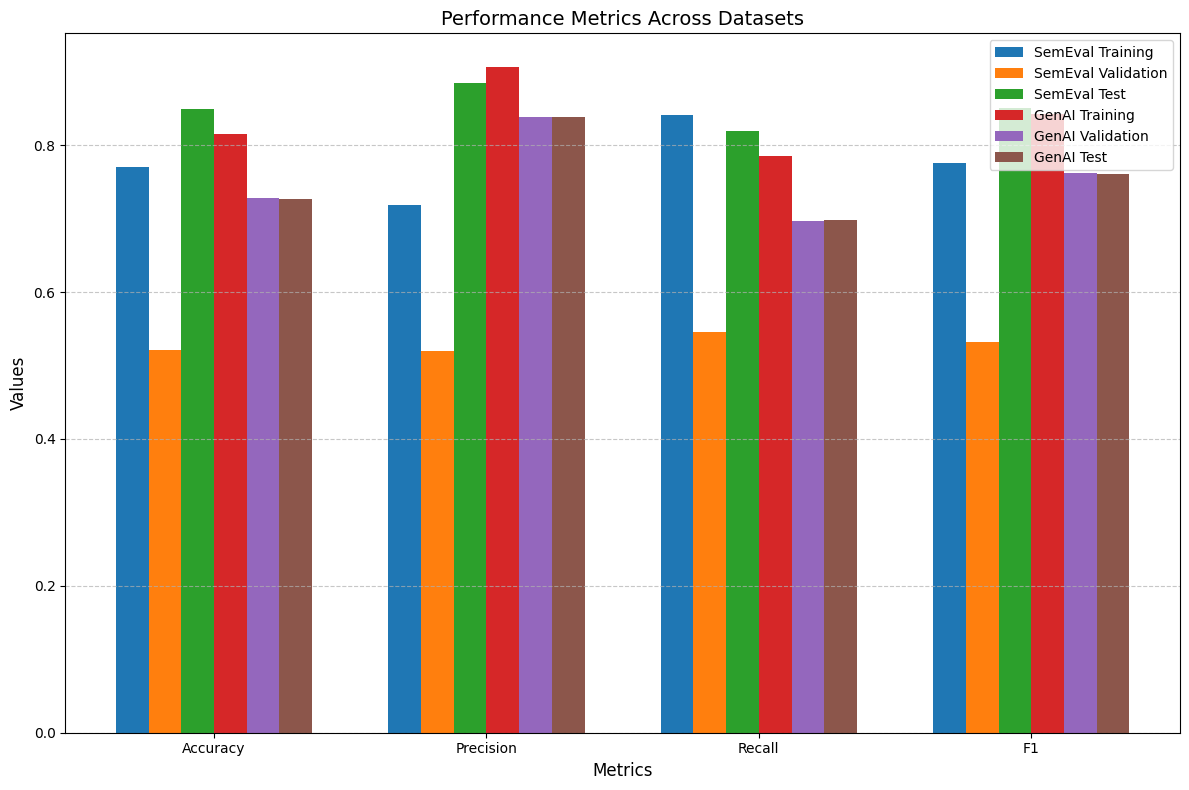

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data
datasets = ["SemEval Training", "SemEval Validation", "SemEval Test",
            "GenAI Training", "GenAI Validation", "GenAI Test"]
metrics = ["Accuracy", "Precision", "Recall", "F1"]

# SemEval metrics
semeval_results = [
    [0.7704, 0.7189, 0.8417, 0.7755],  # Training
    [0.5210, 0.5200, 0.5456, 0.5325],  # Validation
    [0.8488, 0.8840, 0.8196, 0.8506]   # Test
]

# GenAI metrics
genai_results = [
    [0.8156, 0.9069, 0.7857, 0.8420],  # Training
    [0.7274, 0.8389, 0.6972, 0.7615],  # Validation
    [0.7265, 0.8378, 0.6976, 0.7613]   # Test
]

# Combine data for plotting
data = semeval_results + genai_results
data = np.array(data)

# Plotting
x = np.arange(len(metrics))
bar_width = 0.12

plt.figure(figsize=(12, 8))
for i, dataset in enumerate(datasets):
    plt.bar(x + i * bar_width, data[i], width=bar_width, label=dataset)

# Add labels and title
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.title("Performance Metrics Across Datasets", fontsize=14)
plt.xticks(x + bar_width * 2.5, metrics)
plt.legend(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# Additional necessary imports
from sklearn.metrics import accuracy_score

def hyperparameter_tuning_smoothing(train_texts, train_labels, val_texts, val_labels, test_texts, test_labels, smoothing_factors):
    """Tune hyperparameter smoothing factor and evaluate the performance"""
    results = {}

    for smoothing_factor in smoothing_factors:
        print(f"Evaluating with smoothing factor: {smoothing_factor}")

        # Train and evaluate the model with the current smoothing factor
        train_results, val_results, test_results, likelihood = train_and_evaluate_custom(
            train_texts, train_labels,
            val_texts, val_labels,
            test_texts, test_labels,
            smoothing_factor=smoothing_factor  # Pass smoothing factor as argument
        )

        # Save the results for comparison
        results[smoothing_factor] = {
            'train': train_results,
            'val': val_results,
            'test': test_results
        }

        # Print metrics for this smoothing factor
        print(f"Training Accuracy: {train_results['accuracy']}")
        print(f"Validation Accuracy: {val_results['accuracy']}")
        print(f"Test Accuracy: {test_results['accuracy']}")

    # Find the smoothing factor with the best performance on the test set
    best_smoothing_factor = max(results, key=lambda x: results[x]['test']['accuracy'])
    print(f"Best smoothing factor based on test accuracy: {best_smoothing_factor}")

    return results, best_smoothing_factor

def train_and_evaluate_custom(train_texts, train_labels, val_texts, val_labels, test_texts, test_labels, smoothing_factor=0.2):
    """Train and evaluate using custom Naive Bayes implementation for train, validation, and test sets"""
    # Create training dataframe
    train_df = pd.DataFrame({
        'text': [preprocess_text(text) for text in train_texts],
        'label': train_labels
    })

    # Build vocabularies
    full_vocab, human_vocab, machine_vocab = build_vocabulary(train_df)

    # Calculate likelihood with smoothing factor
    likelihood = calculate_log_likelihood(full_vocab, human_vocab, machine_vocab, smoothing_factor=smoothing_factor)

    # Evaluate on train, validation, and test sets
    results_train = evaluate_model(pd.DataFrame({'text': [preprocess_text(text) for text in train_texts], 'label': train_labels}), likelihood)
    results_val = evaluate_model(pd.DataFrame({'text': [preprocess_text(text) for text in val_texts], 'label': val_labels}), likelihood)
    results_test = evaluate_model(pd.DataFrame({'text': [preprocess_text(text) for text in test_texts], 'label': test_labels}), likelihood)

    return results_train, results_val, results_test, likelihood


# Main execution for Hyperparameter Tuning
if __name__ == "__main__":
    # Define smoothing factors to evaluate
    smoothing_factors = [0.1, 0.2, 0.5, 1.0, 2.0, 3.0]

    # Load datasets
    print("Loading datasets...")
    SemEval_train_texts, SemEval_train_labels = get_texts_labels(SemEval_train_file_path)
    SemEval_val_texts, SemEval_val_labels = get_texts_labels(SemEval_val_file_path)
    SemEval_test_texts, SemEval_test_labels = get_texts_labels(SemEval_test_file_path)

    GenAI_train_texts, GenAI_train_labels = get_texts_labels(GenAI_train_file_path)
    GenAI_val_texts, GenAI_val_labels = get_texts_labels(GenAI_val_file_path)

    # Step 1: Split 10% of the GenAI training set for testing and remove it from the training data
    GenAI_train_texts, GenAI_test_texts, GenAI_train_labels, GenAI_test_labels = train_test_split(
        GenAI_train_texts, GenAI_train_labels, test_size=0.1, stratify=GenAI_train_labels, random_state=42
    )

    # Step 2: Stratified Sampling to Match SemEval Dataset Size
    train_data, _ = train_test_split(
        list(zip(GenAI_train_texts, GenAI_train_labels)),
        train_size=len(SemEval_train_texts),
        stratify=GenAI_train_labels,
        random_state=42
    )
    GenAI_train_texts, GenAI_train_labels = map(list, zip(*train_data))

    # Step 3: Hyperparameter tuning with smoothing factors for SemEval dataset
    print("Tuning hyperparameters for SemEval dataset...")
    semeval_results, best_smoothing_factor_semeval = hyperparameter_tuning_smoothing(
        SemEval_train_texts, SemEval_train_labels,
        SemEval_val_texts, SemEval_val_labels,
        SemEval_test_texts, SemEval_test_labels,
        smoothing_factors
    )

    # Step 4: Hyperparameter tuning with smoothing factors for GenAI dataset
    print("Tuning hyperparameters for GenAI dataset...")
    genai_results, best_smoothing_factor_genai = hyperparameter_tuning_smoothing(
        GenAI_train_texts, GenAI_train_labels,
        GenAI_val_texts, GenAI_val_labels,
        GenAI_test_texts, GenAI_test_labels,
        smoothing_factors
    )

    # Print final best results
    print("\nBest smoothing factor for SemEval:", best_smoothing_factor_semeval)
    print("\nBest smoothing factor for GenAI:", best_smoothing_factor_genai)


Loading datasets...
Tuning hyperparameters for SemEval dataset...
Evaluating with smoothing factor: 0.1
Training Accuracy: 0.7824928814182052
Validation Accuracy: 0.5204
Test Accuracy: 0.8479808590102708
Evaluating with smoothing factor: 0.2
Training Accuracy: 0.7704267808979851
Validation Accuracy: 0.521
Test Accuracy: 0.8487686741363212
Evaluating with smoothing factor: 0.5
Training Accuracy: 0.7538682498726588
Validation Accuracy: 0.5204
Test Accuracy: 0.8488270308123249
Evaluating with smoothing factor: 1.0
Training Accuracy: 0.7405913641791294
Validation Accuracy: 0.5206
Test Accuracy: 0.8466970121381886
Evaluating with smoothing factor: 2.0
Training Accuracy: 0.7223878353666174
Validation Accuracy: 0.5186
Test Accuracy: 0.8380018674136321
Evaluating with smoothing factor: 3.0
Training Accuracy: 0.7078918142572042
Validation Accuracy: 0.5182
Test Accuracy: 0.8260387488328664
Best smoothing factor based on test accuracy: 0.5
Tuning hyperparameters for GenAI dataset...
Evaluating wi

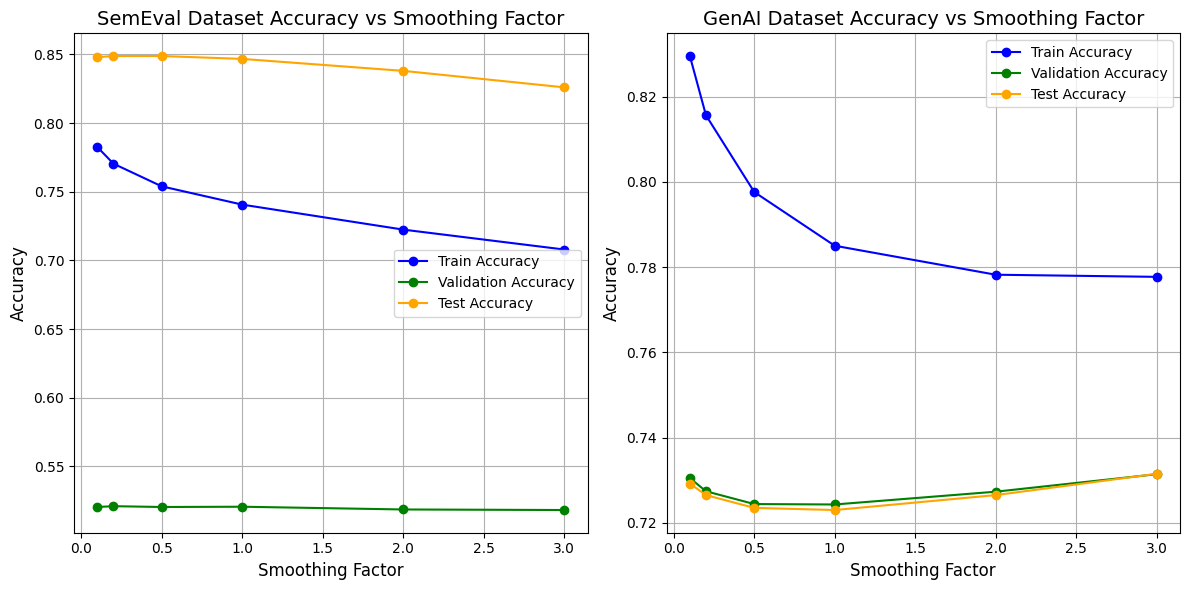

In [1]:
import matplotlib.pyplot as plt

# Data for SemEval dataset
smoothing_factors = [0.1, 0.2, 0.5, 1.0, 2.0, 3.0]
semeval_train_acc = [0.7825, 0.7704, 0.7539, 0.7406, 0.7224, 0.7079]
semeval_val_acc = [0.5204, 0.521, 0.5204, 0.5206, 0.5186, 0.5182]
semeval_test_acc = [0.8480, 0.8488, 0.8488, 0.8467, 0.8380, 0.8260]

# Data for GenAI dataset
genai_train_acc = [0.8295, 0.8156, 0.7976, 0.7850, 0.7782, 0.7777]
genai_val_acc = [0.7305, 0.7274, 0.7244, 0.7243, 0.7273, 0.7314]
genai_test_acc = [0.7292, 0.7265, 0.7235, 0.7230, 0.7265, 0.7315]

# Plotting accuracy trends for SemEval
plt.figure(figsize=(12, 6))

# SemEval dataset plot
plt.subplot(1, 2, 1)
plt.plot(smoothing_factors, semeval_train_acc, marker='o', label='Train Accuracy', color='blue')
plt.plot(smoothing_factors, semeval_val_acc, marker='o', label='Validation Accuracy', color='green')
plt.plot(smoothing_factors, semeval_test_acc, marker='o', label='Test Accuracy', color='orange')
plt.title('SemEval Dataset Accuracy vs Smoothing Factor', fontsize=14)
plt.xlabel('Smoothing Factor', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

# GenAI dataset plot
plt.subplot(1, 2, 2)
plt.plot(smoothing_factors, genai_train_acc, marker='o', label='Train Accuracy', color='blue')
plt.plot(smoothing_factors, genai_val_acc, marker='o', label='Validation Accuracy', color='green')
plt.plot(smoothing_factors, genai_test_acc, marker='o', label='Test Accuracy', color='orange')
plt.title('GenAI Dataset Accuracy vs Smoothing Factor', fontsize=14)
plt.xlabel('Smoothing Factor', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
